In [19]:
## Generate data series
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as stm
import statsmodels.formula.api as smf
import statsmodels.distributions.empirical_distribution

np.random.seed(1234567)
stochastic_baseline = np.random.normal (0, 0.5, 1440)
failure_stochastic = np.random.exponential(0.01, 1440)

Data Generation

In [20]:
mydata = np.random.normal(89, 2.5, 1440)
pt_num = range(len(mydata))
mydf = pd.DataFrame({'pt_num': pt_num, 'data': mydata})

In [21]:
def plot_data (mydf, col2plot = 'data', alias = 'temperature'):
    fig, ax = plt.subplots(figsize=(11,8.5))
    pt_num = list(mydf.index)
    mydata = mydf[col2plot]
    
    plt.plot(pt_num, mydata)
    ax.set_ylabel(alias)
    plt.show()

In [22]:
def plot_cdf (myCDFdf, xlabel = 'pctl', col2plot = 'prob'):
    fig, ax = plt.subplots(figsize=(11,8.5))
    
    plt.plot(myCDFdf['pctl'], myCDFdf[col2plot])
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(col2plot, fontsize=16)
    plt.show()

In [23]:
def plot_hist(mydf, col2plot='data', alias='Temperature'):
    fig, ax = plt.subplots(figsize=(11,8.5))
    mydata = mydf[col2plot]
    myHist = plt.hist(mydata);
    ax.set_title ('Histogram', fontsize=18)
    ax.set_xlabel('Temperature', fontsize=16)
    ax.set_ylabel('Number of points', fontsize=16)
    plt.show()
    return (myHist)

## Consider a normally distributed random variable (e.g., temperature).

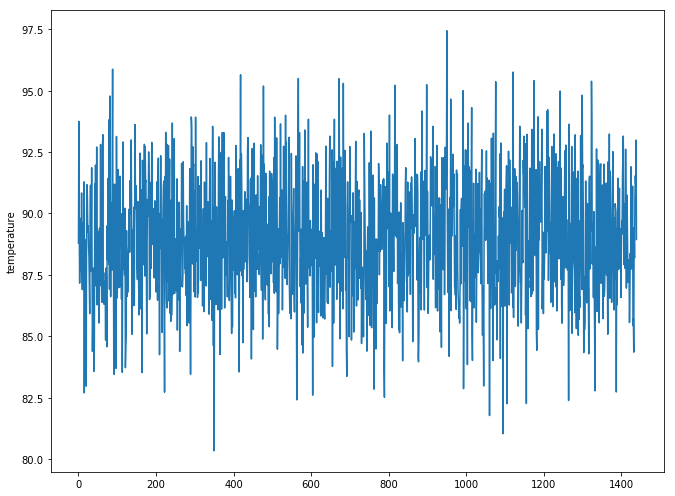

In [24]:
plot_data(mydf)

Its histogram will look like below:

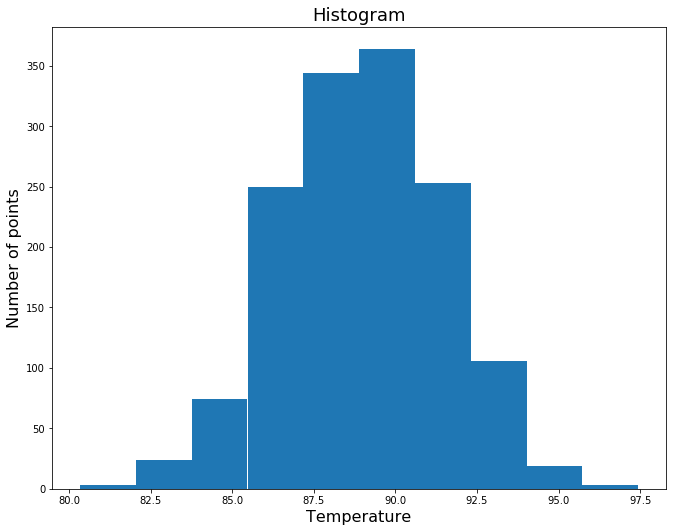

In [25]:
myHist = plot_hist(mydf, 'data', 'Temperature')

A look at the histogram object reveals that it is a pair of arrays, aligned by indices, where the first array is the number of points in the bin, and the second array is the starting point of a bin - which is shown in the bar chart above:  The binning logic in this case broke the data into 10 bins, but it could be more, as well as fewer, depending on the binning rules and distribution statistics:

In [26]:
myHist

(array([  3.,  24.,  74., 250., 344., 364., 253., 106.,  19.,   3.]),
 array([80.33510044, 82.04512954, 83.75515863, 85.46518772, 87.17521681,
        88.8852459 , 90.59527499, 92.30530409, 94.01533318, 95.72536227,
        97.43539136]),
 <a list of 10 Patch objects>)

The histogram is an approximation of the $\textit{Probability Density Function}$, or $PDF$.  Density implies that there is some differentiation (taking derivatives) involved.  Its integrated (cumulative) form is known as $\textit{Cumulative Distribution Function}$, or 

$$CDF = \int_{min}^{max} PDF(x) dx$$.  
Its approximated version can be obtained by using cumulative sum of the histogram values (first array):

In [27]:
myCDF = [list(myHist[1])]
cum_sum = [0]
cum_sum.extend(list(np.cumsum(myHist[0])))
myCDF.append(cum_sum)
myCDF.append([cc/max(myCDF[1]) for cc in myCDF[1]])
myCDF
[len(cc) for cc in myCDF]
myCDFdf = pd.DataFrame({'pctl': myCDF[0], 'count': myCDF[1], 'prob': myCDF[2]})
myCDFdf

,pctl,count,prob
0,80.335100,0.0,0.000000
1,82.045130,3.0,0.002083
2,83.755159,27.0,0.018750
3,85.465188,101.0,0.070139
4,87.175217,351.0,0.243750
5,88.885246,695.0,0.482639
6,90.595275,1059.0,0.735417
7,92.305304,1312.0,0.911111
8,94.015333,1418.0,0.984722
9,95.725362,1437.0,0.997917


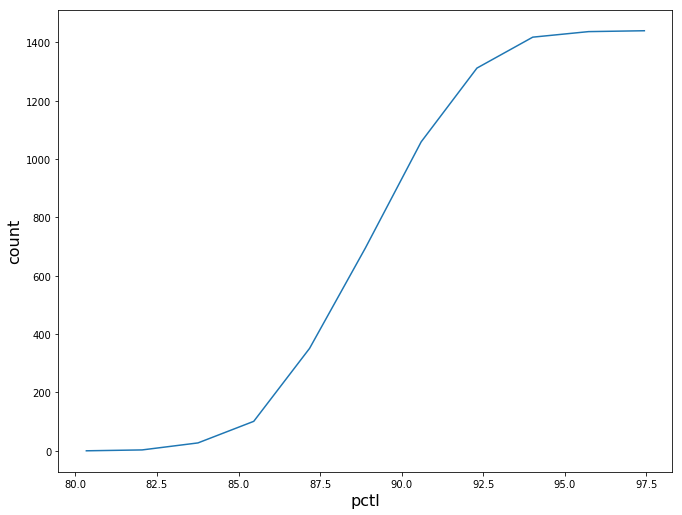

In [28]:
plot_cdf(myCDFdf, col2plot='count')

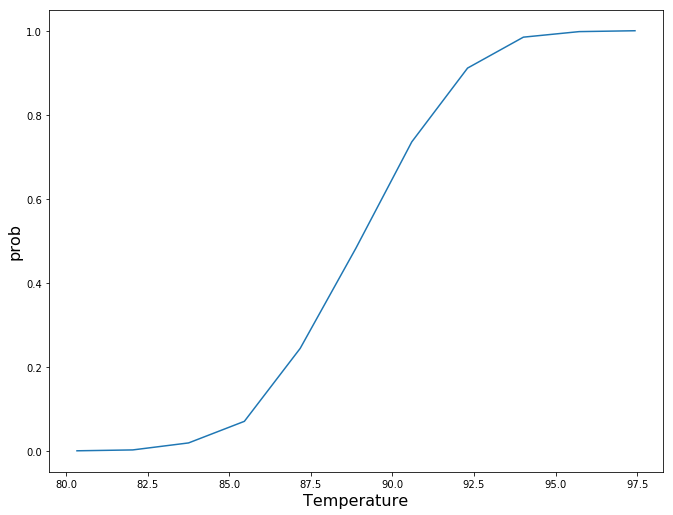

In [29]:
plot_cdf(myCDFdf, xlabel='Temperature', col2plot='prob')

## And this is where things get interesting.

CPU utilization is by definition the number of cycles (ticks) that CPU is busy divided by the total number of cycles that the CPU has ticked:

$$ \rho_{CPU} = \frac{N_{busy}}{N_{total}} $$

We can interpret this as the probability that we will find CPU busy:

$$ Pr\{busy\} = \rho_{CPU} $$

Then, if we plot CPU utilization as a function of, e.g., traffic to your site, or number of customer transactions, or any other or system KPI, and we see that the fit is approximately linear, we have to be careful where we measure it: the linearity may be misleading.

In [30]:
myCDFdf = myCDFdf.rename(index=str, columns={'prob': 'Utilization'})

In [31]:
loCPUrho = myCDFdf.loc[myCDFdf['pctl'] < 90].copy()
hiCPUrho = myCDFdf.loc[myCDFdf['pctl'] >= 90].copy()
loCPUrho['Utilization'] = min(hiCPUrho['Utilization'])
loCPUrho

cpuRhoTemp = pd.concat([loCPUrho, hiCPUrho])
cpuRhoTemp

,pctl,count,Utilization
0,80.335100,0.0,0.735417
1,82.045130,3.0,0.735417
2,83.755159,27.0,0.735417
3,85.465188,101.0,0.735417
4,87.175217,351.0,0.735417
5,88.885246,695.0,0.735417
6,90.595275,1059.0,0.735417
7,92.305304,1312.0,0.911111
8,94.015333,1418.0,0.984722
9,95.725362,1437.0,0.997917


## Scenario for modeling:

Modern Intel CPUs have a thermal-throttling operation mode: when the device temperature reaches $90$ degrees Celsius,  it starts throttling the CPU frequency.

In queueing-theory terms,

$$ \rho = \frac{\lambda}{\mu} $$

where $\lambda$ is the arrival rate of the CPU instructions, and $\mu$ is the CPU frequency.  We assume that $\lambda < \mu$ (the system is is stable).  When the frequency ($\mu$) goes down, the CPU utilization $\rho$ necessarily goes up, like in the figure below.

Here the $\lambda$ was stable, and utilization was stable as well at about $73\%$, as the $\mu$ was stable. In this scenario, the CPU cooling system was sub-optimal (air obstructions, dusty radiators, ...), so the temperature kept increasing.  At $90$ degrees, throttling kicked in, which caused CPU utilization to grow, even though $\lambda$ stayed stable:

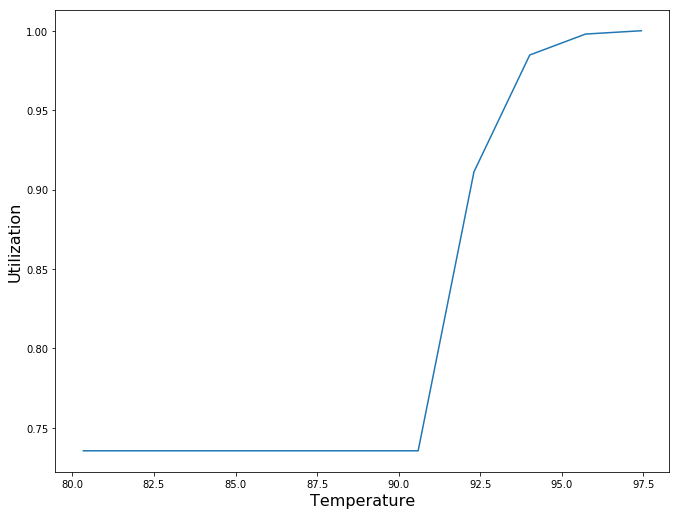

In [32]:
plot_cdf(cpuRhoTemp, 'Temperature', 'Utilization')

## Logistic Regression

It's clear from this picture that if the temperature happens to be between $91$ and $93$ degrees, we can have a good fit from a linear model.  But for the tails, it won't work.  

So what can we do?  It's a two-step process called $\textbf{logistic (or logit) transformation}$.  We must recall that $ Pr\{busy\} = \rho_{CPU} $ ad compute the odds ratio of finding the CPU busy:

$$ R_{odds} = \frac{\rho}{1 - \rho} $$ 

Computationally, to a void division by zero, we will modify this equation:

$$ R_{odds} = \frac{\rho}{1 + \epsilon - \rho}, $$

where $\epsilon \ll 1.0$ 


In [33]:
cpuRhoTemp['odds_ratio'] = 0.001+cpuRhoTemp['Utilization']/(1.001-cpuRhoTemp['Utilization']) 
cpuRhoTemp

,pctl,count,Utilization,odds_ratio
0,80.335100,0.0,0.735417,2.770062
1,82.045130,3.0,0.735417,2.770062
2,83.755159,27.0,0.735417,2.770062
3,85.465188,101.0,0.735417,2.770062
4,87.175217,351.0,0.735417,2.770062
5,88.885246,695.0,0.735417,2.770062
6,90.595275,1059.0,0.735417,2.770062
7,92.305304,1312.0,0.911111,10.136970
8,94.015333,1418.0,0.984722,60.495881
9,95.725362,1437.0,0.997917,323.649649


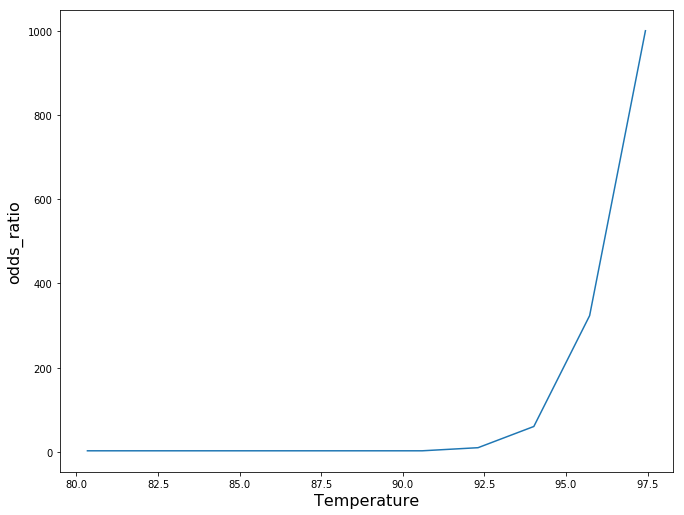

In [34]:
plot_cdf(cpuRhoTemp, col2plot='odds_ratio', xlabel='Temperature')

This looks like an exponential curve (and mathematically it is, due to the specifics of Normal distribution);  we should take the log of it:

$$ Y' = ln(R_{odds}) = ln{\left[\frac{\rho}{1 + \epsilon - \rho} \right]}, $$

where $\epsilon \ll 1.0$ 


In [35]:
cpuRhoTemp['log_odds'] = np.log(cpuRhoTemp['odds_ratio'])
cpuRhoTemp

,pctl,count,Utilization,odds_ratio,log_odds
0,80.335100,0.0,0.735417,2.770062,1.018870
1,82.045130,3.0,0.735417,2.770062,1.018870
2,83.755159,27.0,0.735417,2.770062,1.018870
3,85.465188,101.0,0.735417,2.770062,1.018870
4,87.175217,351.0,0.735417,2.770062,1.018870
5,88.885246,695.0,0.735417,2.770062,1.018870
6,90.595275,1059.0,0.735417,2.770062,1.018870
7,92.305304,1312.0,0.911111,10.136970,2.316189
8,94.015333,1418.0,0.984722,60.495881,4.102575
9,95.725362,1437.0,0.997917,323.649649,5.779662


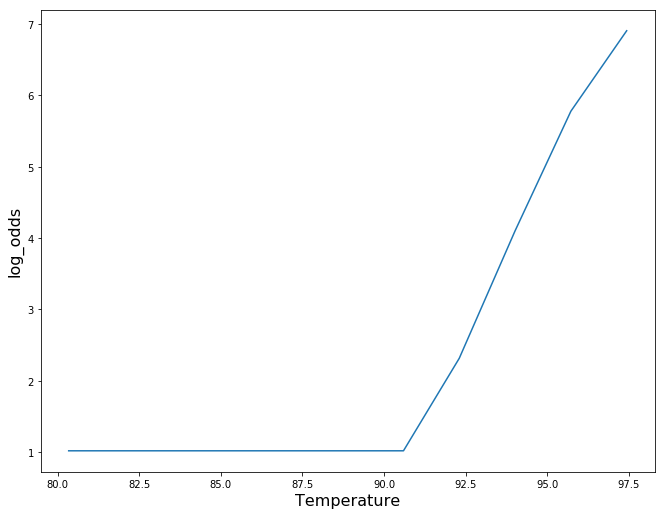

In [36]:
plot_cdf(cpuRhoTemp, col2plot='log_odds', xlabel='Temperature')

Above the temperature of $90$ degrees, this is an approximately linear curve, and we should be able to fit a linear model into these data.  This curve applies to the entire range of temperatures, and even beyond that.  More importantly, a simple conversion will return the prediction back to the $[0...1]$ range:

$$ Y' = \beta_0 + \beta_1 * X, $$

where

$$ Y' = \ln{\left[\frac{\rho}{1 + \epsilon - \rho}\right] = \beta_0 + \beta_1 * X} $$

Then

$$ \rho = \frac{e^{Y'}}{1 + \epsilon + e^{Y'}}. $$

Finally,

$$ \rho = \frac{e^{\beta_0 + \beta_1 * X}}{1 + \epsilon + e^{\beta_0 + \beta_1 * X}}, $$

or:

$$ \rho = \frac{e^{\beta_0} * e^{\beta_1 * X}}{1 + \epsilon + e^{\beta_0} * e^{\beta_1 * X}} $$

$$ \rho = \frac{e^{\beta_0} * e^{\beta_1 * T}}{1 + e^{\beta_0} * e^{\beta_1 * T}} $$


The final equation can be used to compute the utilization predicted by the model outside the range where the original curve looked linear: just plug in the $\beta_0$, $\beta_1$, and the $T$, and we will have the CPU utilization that will not exceed $100\%$ and will not drop below $0$